 ## Первый раздел.
 ### Импорт библиотек, подключение CUDA devices

In [1]:
!pip install numba
!pip install py-cpuinfo

from datetime import datetime
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from tabulate import tabulate
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
from google.colab.patches import cv2_imshow
from numba import cuda, jit, int32, int64
from math import ceil
from time import time

import matplotlib.pyplot as plt
import numpy as np
import cpuinfo
import math
import numba
import pandas as pd
import time
import cv2
import datetime

     |████████████████████████████████| 99 kB 6.6 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=37dba632784fb5eca817456601d852363ada2a6bc32f3b039b17365c6ca56d4c
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


### *Проверяем, какое оборудование у нас подключенно.*:

In [2]:
print('----------------------------------------------------------------------')
print('CPU, выделенный на сервере Colaboratory:', cpuinfo.get_cpu_info()['brand_raw'])
print('GPU, выделенный на сервере Colaboratory:', cuda.get_current_device())
print('----------------------------------------------------------------------')
numba.cuda.detect()

----------------------------------------------------------------------
CPU, выделенный на сервере Colaboratory: Intel(R) Xeon(R) CPU @ 2.30GHz
GPU, выделенный на сервере Colaboratory: <CUDA device 0 'b'Tesla K80''>
----------------------------------------------------------------------
Found 1 CUDA devices
id 0            b'Tesla K80'                              [SUPPORTED]
                      compute capability: 3.7
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

In [3]:
!pip install pycuda
from pycuda import driver, compiler
from pycuda.compiler import SourceModule
import pycuda.autoinit

     |████████████████████████████████| 1.7 MB 12.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.7 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626633 sha256=23e50f2afc8858997d3ca43746bc2bc58cb05872d02b8e4d05093d698def0928
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=90803bf79a4eb6e4b8ec465f209834b59d38e1fa11e4e0ae8bb9d624e2a31567
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


### Второй раздел.
Скачиваем изображение. <br/>
Вычисления на CPU.  <br/>

In [4]:
img_bat = cv2.imread('sample_data/original_image_batman.bmp')

Для выполнения двусторонней фильтрации в Python OpenCV существует функция, называемая `bilateralFilter()`

> Синтаксис
>
>  cv2.bilateralFilter(src, dst, d, sigmaColor, sigmaSpace, borderType =  BORDER_DEFAULT) 



Параметры: <br>

- src Это изображение, которое нужно размыть.<br>
- dst Целевое изображение того же размера и типа, что и src.<br>
- d Диаметр каждой окрестности пикселя, которая используется во время фильтрации. Если он неположителен, он вычисляется из sigmaSpace.<br>
- sigmaColor Фильтр сигма в цветовом пространстве. Большее значение параметра означает, что более дальние цвета в окрестности пикселя будут смешиваться друг с другом, что приведет к получению больших областей полуравномерного цвета.<br>
- sigmaSpace Фильтр сигмы в координатном пространстве. Большее значение параметра означает, что дальние пиксели будут влиять друг на друга, пока их цвета достаточно близки. Когда d>0, он указывает размер окрестности независимо от sigmaSpace. В противном случае d пропорционально sigmaSpace.<br>
- borderType, Пограничный режим используемый для экстраполяции пикселей за пределы изображения.<br>


In [5]:
time_CPU = time.time()
bil_img_bat = cv2.bilateralFilter(img_bat, 5, 2000, 1000)
time_CPU = (time.time() - time_CPU) 

print('----------------------------------------------------------------------')
print(f"Время выполнения на CPU: {round(time_CPU,4)} second.")
print('----------------------------------------------------------------------')

----------------------------------------------------------------------
Время выполнения на CPU: 0.0192 second.
----------------------------------------------------------------------


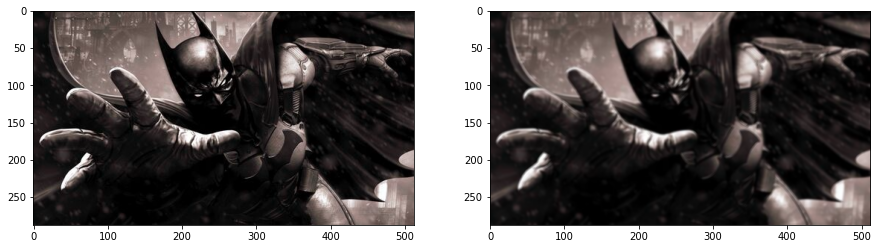

In [6]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(img_bat)
plt.subplot(1, 2, 2)
plt.imshow(bil_img_bat)

In [7]:
cv2.imwrite('sample_data/bilateral_image_on_CPU.bmp', bil_img_bat)#Сохраняем результат

True

### Третий раздел.

*Вычисления на GPU.* <br/>

In [8]:
from pycuda.compiler import SourceModule
filter_GPU = SourceModule("""
texture<unsigned int, 2> tex;

__global__ void kernel(unsigned int * __restrict__ image, const int M, const int N, const float gg)
{
    //получаем номер нити
    const int x = threadIdx.x + blockDim.x * blockIdx.x;
    const int y = threadIdx.y + blockDim.y * blockIdx.y;

    //проверяем что не вышли за рамки изображения
    if ((x < M) && (y < N)) {

        //это центральный пиксель, который мы обрабатываем
        float fa0 = tex2D(tex, x, y);
        float SumK = 0;
        float SumHP = 0;

        for (int a = x-1; a <= x+1; a++){
            for (int b = y-1; b <= y+1; b++){

                //получаем пиксели, которые располагаются вокруг центрального
                float fai = tex2D(tex, b, a);

                //далее рассчитываем всё по формулам, как и в методе для cpu
                float r = exp(-pow((fai - fa0), 2) / pow(gg, 2));
                
                float g = exp(-(pow(b - x, 2) + pow(a - y, 2)) / pow(gg, 2));
               
                SumK += g*r;
                SumHP += g*r*tex2D(tex, b, a);
            }
        }
        image[x*N + y] = SumHP / SumK;
    }
}""")

kernel = filter_GPU.get_function("kernel")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



In [9]:
BLOCK_SIZE = 16
gg = 200
img_bat = cv2.imread('sample_data/original_image_batman.bmp', cv2.IMREAD_GRAYSCALE)
M,N = img_bat.shape
grid = (int(np.ceil(M/BLOCK_SIZE)),int(np.ceil(N/BLOCK_SIZE)))

time_GPU = time.time()

#Копируем данные в текстуру
cu_tex = filter_GPU.get_texref("tex")
driver.matrix_to_texref(img_bat.astype(np.int32), cu_tex, order="C")

#Запускаем функцию ядра
bil_img_bat_GPU = np.zeros((M,N), dtype=np.int32)
kernel(driver.Out(bil_img_bat_GPU), 
       np.int32(M), np.int32(N), 
       np.float32(gg),
       texrefs=[cu_tex], 
       block=(BLOCK_SIZE,BLOCK_SIZE,1), 
       grid=grid)

time_GPU = (time.time() - time_GPU) 

print('----------------------------------------------------------------------')
print(f"Время выполнения на GPU: {round(time_GPU,4)} second.")
print('----------------------------------------------------------------------')

----------------------------------------------------------------------
Время выполнения на GPU: 0.0056 second.
----------------------------------------------------------------------


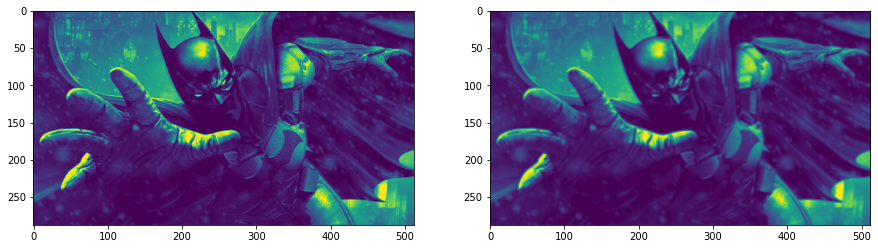

In [10]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(img_bat)
plt.subplot(1, 2, 2)
plt.imshow(bil_img_bat_GPU)

In [11]:
#Сохраняем результат
cv2.imwrite('sample_data/bilateral_image_on_GPU.bmp', bil_img_bat_GPU.astype(np.uint8))



True